In [10]:
# Mathematical operations
import numpy as np
import pandas as pd

# Deep learning library + differentiable QP solver
import torch
try:
    import qpth
except ModuleNotFoundError:
    !pip install git+https://github.com/locuslab/qpth
    import qpth

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Functions and classes in models.py
from models import fix_seed_and_device, train, plot_progression, OptNetDenoiser, DenseNetDenoiser

# Others
import warnings
from typing import Optional, Callable, Literal

warnings.filterwarnings('ignore')

In [11]:
device = fix_seed_and_device()
print(device)

cpu


# Denoising problem

Given a noised time series $y\in\mathbb R^T$, we want to denoise it, i.e., we want to find a time series $z^*$ that is as close as possible to $y$, but satisfies some regularity condition. The **total variation denoising method** (TV) consists in solving the following problem:

\begin{equation}
    z^* \in \arg\min_{z\in\mathbb R^T} \frac12|\!|y-z|\!|_2^2 + \lambda |\!|Dz|\!|_1
\end{equation}

where $\lambda > 0$ is a hyperparameter and $D\in\mathbb R^{(T-1)\times T}$ maps $z$ to its temporal differences $Dz=(z_2-z_1, z_3-z_2,\cdots,z_T-z_{T-1})^\top$.

This problem can be approximated by an OptNet. In fact, by the Lagrange multiplier theorem, this problem is equivalent to

\begin{equation}
    z^* \in \arg\min_{z\in\mathbb R^T} \frac12|\!|y-z|\!|_2^2 \quad \text{subject to} \quad  |\!|Dz|\!|_1 \leq \vartheta
\end{equation}

for some $\vartheta > 0$. This constraint forces $Dz$ to belong in an $\ell_1$ ball, which is in fact a polytope. The constraint can thus be re-written as 

\begin{equation}
    z^* \in \arg\min_{z\in\mathbb R^T} \frac12|\!|y-z|\!|_2^2 \quad \text{subject to} \quad  \Gamma Dz \leq \theta
\end{equation}

where $\Gamma \in\mathbb \{-1,1\}^{2^{T-1}\times T-1}$ is a matrix obtained by stacking all $2^{T-1}$ elements of $\{-1,1\}^{T-1}$, and $\theta\in\mathbb R^{T-1}$ is a vector whose entries are all equal to $\vartheta$.
Finally, the objective function is clearly quadratic in $z$, yielding the following representation:

\begin{equation}
    z^* \in \arg\min_{z\in\mathbb R^T} \frac12z^\top z - z^\top y \quad \text{subject to} \quad  \Gamma Dz \leq \theta
\end{equation}

which corresponds to a usual quadratic program with $Q=I_T$, $p=-y$, $G=\Gamma D$, $h=\theta$, and no equality constraints. In practice, $\Gamma D$ and $\theta$ have too many lines ($2^{T-1}$) to be used, so we will reduce the number of inequality constraints to make the problem solvable. In our experiment, we set the number of inequality constraints to $2(T-1)$ and initialize $\Gamma$ as $$ \Gamma = \begin{pmatrix} I_{T-1} \\ -I_{T-1} \end{pmatrix} $$ so that the constraint $\Gamma Dz \leq \theta$ is equivalent to $|\!|Dz|\!|_\infty \leq \vartheta$.

The model will learn the product $G=\Gamma D \in\mathbb R^{2(T-1)\times T}$ as well as $\vartheta\in\mathbb R$. Learning $D$ allows to modify the regularity constraint imposed to $z^*$. We initialize $D$ as the matrix of the first-difference operator, as in the TV method.

# 1. Dataset generation

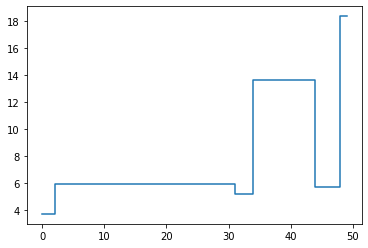

In [12]:
def generate_piecewise_constant(length:int, min_steps=1, max_steps=7, min_value=0, max_value=20):
    """
    Randomly generates a piecewise-constant time series of the given length.
    The locations of the discontinuities are selected uniformly. 
    The values on the different intervals are also uniform draws.
    """
    nb_jumps = np.random.randint(min_steps, max_steps+1)
    jumps = sorted(np.random.randint(length, size=nb_jumps))
    jumps = [0, *jumps, length]
    y = np.zeros(length)
    for i in range(len(jumps)-1):
        y[ jumps[i] : jumps[i+1] ] = np.random.uniform(min_value, max_value)
    return y

plt.step(x=range(50), y=generate_piecewise_constant(50), where='pre');

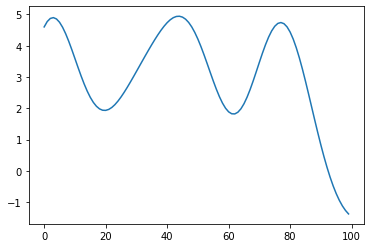

In [13]:
def generate_sinusoidal(length:int, min_components=3, max_components=5, min_amplitude=1, max_amplitude=20):
    """
    Randomly generates a sinusoidal time series of the given length.
    The locations of the discontinuities are selected uniformly. 
    The values on the different intervals are also uniform draws.
    """
    nb_components = np.random.randint(min_components, max_components+1)
    timesteps = np.indices((length,)).reshape(length)
    components = []
    for i in range(nb_components):
        freq = (i+1)/10
        ampl = np.random.uniform(min_amplitude, max_amplitude) / nb_components
        offset = np.random.uniform(0, 2*np.pi)
        component = ampl * np.sin( freq * (freq*timesteps + offset) )
        components.append(component)
    return sum(components)

plt.plot(generate_sinusoidal(100));

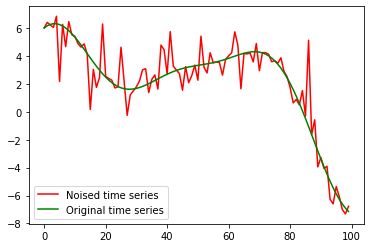

In [14]:
def add_gaussian_noise(y:np.ndarray, sigma:float=1):
    """
    Corrupts the time series y with a white gaussian noise.
    """
    return y + np.random.normal(loc=0, scale=sigma, size=y.shape)

def add_normal_gamma_noise(y:np.ndarray, alpha:float=1, beta:float=1):
    """
    Corrupts the time series y with a random noise.
    The noise at time t is drawn from a normal-gamma distribution with parameters (0, 1, alpha, beta).
    """
    sigmas = np.random.gamma(1, 1, size=y.shape)
    noise = np.vectorize(lambda sigma: np.random.normal(loc=0, scale=sigma))(sigmas)
    return y + noise


def plot(
        original: np.ndarray,
        noised: np.ndarray,
        plot_type: Literal['curve', 'step'] = 'step',
        **denoised: np.ndarray,
        
    ):
    """
    Compares an original, noised, and (optionally) denoised signal(s) on a single plot.
    The argument `plot_type' indicates if `plt.plot' or `plt.step' should be used, depending on whether the signal is sinusoidal or piecewise-constant.
    The denoised time series should be passed as keyword arguments (the keyword used will appear in the legend).
    """
    fig, ax = plt.subplots(figsize=(6,4))
    ts = np.arange(noised.shape[0])
    plot_func = ax.plot if plot_type == 'curve' else ax.step
    plot_func(ts, noised, color='red', label='Noised time series')
    for i, (model_name, dn) in enumerate(denoised.items()):
        plot_func(ts, dn, color=['blue', 'orange'][i], label=model_name)
    plot_func(ts, original, color='green', label='Original time series')
    ax.legend()
    return fig, ax

y = generate_sinusoidal(100)
n = add_normal_gamma_noise(y)
plot(y, n, plot_type='curve');

In [15]:
class DenoisingDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            length: int = 20,
            size: int = 1_000,
            series_generation_function: Callable = generate_piecewise_constant,
            noise_func: Callable = add_gaussian_noise,
            **noise_func_kwargs
        ):
        self.original, self.noised = [], []
        for _ in range(size):
            y = series_generation_function(length)
            self.original.append(torch.from_numpy(y).float())
            n = noise_func(y, **noise_func_kwargs)
            self.noised.append(torch.from_numpy(n).float())
    
    def __len__(self):
        return len(self.original)
    
    def __getitem__(self, idx:int):
        return dict(
            original = self.original[idx],
            noised = self.noised[idx]
        )

SERIES_LENGTH = 50

trainset = DenoisingDataset(
    length=SERIES_LENGTH, size=1_000, series_generation_function=generate_piecewise_constant, noise_func=add_normal_gamma_noise
)
valset = DenoisingDataset(
    length=SERIES_LENGTH, size=200, series_generation_function=generate_piecewise_constant, noise_func=add_normal_gamma_noise
)
testset = DenoisingDataset(
    length=SERIES_LENGTH, size=200, series_generation_function=generate_piecewise_constant, noise_func=add_normal_gamma_noise
)

# 2. Denoising piecewise-constant signals

           Test MSE
Dense Net  1.274887
OptNet     1.630323


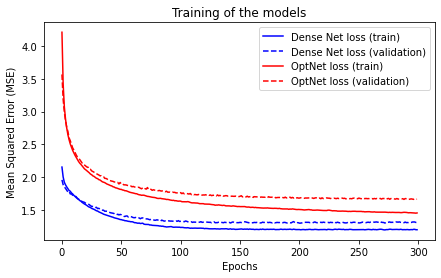

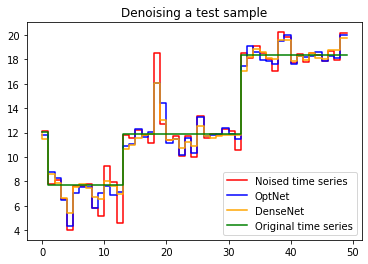

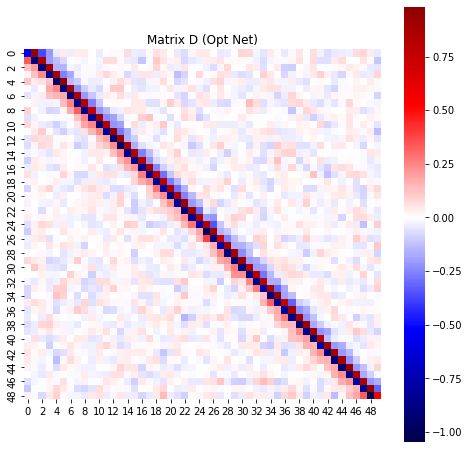

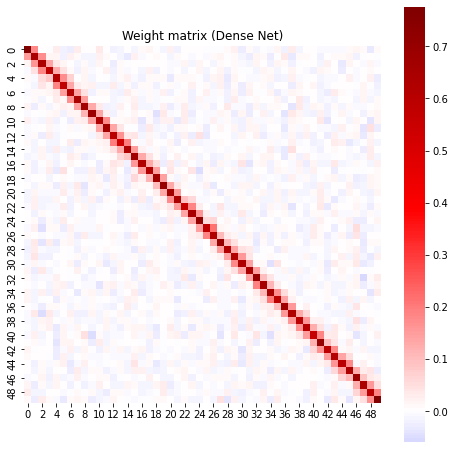

In [16]:
def main(trainset, valset, testset, batch_size=100, plot_type='curve'):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    ## Training
    densenet = DenseNetDenoiser(SERIES_LENGTH, init_mode='ma')
    train_losses_densenet, val_losses_densenet, densenet = train(
        model = densenet,
        train_loader = trainloader,
        val_loader = valloader,
        optimizer = torch.optim.Adam(densenet.parameters(), lr=.001),
        loss_fn = torch.nn.MSELoss(),
        n_epochs = 300
    )

    optnet = OptNetDenoiser(SERIES_LENGTH, init_mode='tv')
    train_losses_optnet, val_losses_optnet, optnet = train(
        model = optnet,
        train_loader = trainloader,
        val_loader = valloader,
        optimizer = torch.optim.Adam(optnet.parameters(), lr=.001),
        loss_fn = torch.nn.MSELoss(),
        n_epochs = 300
    )

    ## Loss over time
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(train_losses_densenet, color='blue', label='Dense Net loss (train)')
    ax.plot(val_losses_densenet, color='blue', linestyle='dashed', label='Dense Net loss (validation)')
    ax.plot(train_losses_optnet, color='red', label='OptNet loss (train)')
    ax.plot(val_losses_optnet, color='red', linestyle='dashed', label='OptNet loss (validation)')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Squared Error (MSE)')
    ax.legend()
    ax.set_title("Training of the models")
    fig.show()

    ## Example
    original = trainset[0]['original']
    noised = trainset[0]['noised']
    denoised_densenet = densenet(noised).squeeze().detach()
    denoised_optnet = optnet(noised).squeeze().detach()
 
    fig2, ax2 = plot(
        original = original,
        noised = noised,
        OptNet = denoised_optnet,
        DenseNet = denoised_densenet,
        plot_type = plot_type
    )
    ax2.set_title("Denoising a test sample")
    fig2.show()

    ## Matrix D
    fig3, ax3 = plt.subplots(figsize=(8,8))
    sns.heatmap(
        optnet.D.data.detach().numpy(),
        cmap = 'seismic',
        square = True,
        center = 0,
        ax = ax3
    )
    ax3.set_title("Matrix D (Opt Net)")
    plt.axis('off')
    fig3.show()

    ## Dense net's weight matrix
    fig4, ax4 = plt.subplots(figsize=(8,8))
    sns.heatmap(
        densenet.linear.weight.data.detach().numpy(),
        cmap = 'seismic',
        square = True, 
        center = 0,
        ax = ax4
    )
    ax4.set_title("Weight matrix (Dense Net)")
    plt.axis('off')
    fig4.show()

    ## Test MSE
    with torch.no_grad():
        densenet_loss, optnet_loss = 0, 0
        loss_fn = torch.nn.MSELoss()
        for batch in testloader:
            noised = batch['noised']
            target = batch['original']

            out = optnet(noised)
            optnet_loss += loss_fn(out, target).item()

            out = densenet(noised)
            densenet_loss += loss_fn(out, target).item()
    
    print(pd.DataFrame(
        data = [densenet_loss/len(testloader), optnet_loss/len(testloader)],
        columns = ["Test MSE"],
        index = ["Dense Net", "OptNet"]
    ))

main(trainset, valset, testset, plot_type='step')

# 3. Experiment on sinusoidal signals

           Test MSE
Dense Net  0.263180
OptNet     0.279366


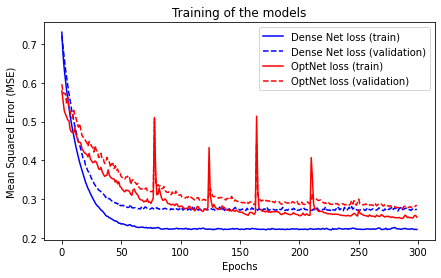

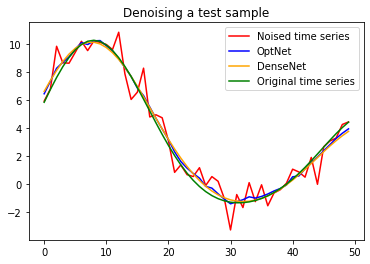

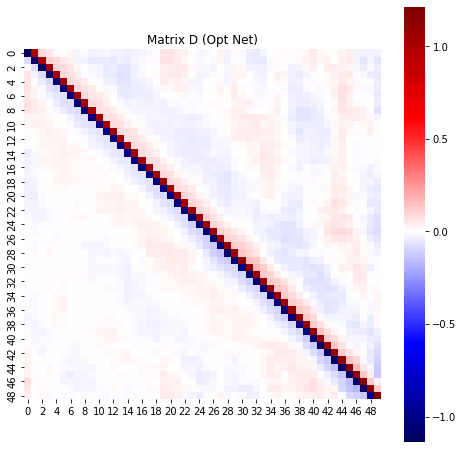

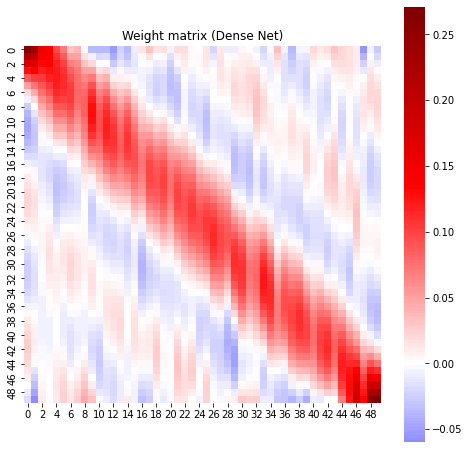

In [17]:
trainset = DenoisingDataset(
    length=SERIES_LENGTH, size=1_000, series_generation_function=generate_sinusoidal, noise_func=add_normal_gamma_noise
)
valset = DenoisingDataset(
    length=SERIES_LENGTH, size=200, series_generation_function=generate_sinusoidal, noise_func=add_normal_gamma_noise
)
testset = DenoisingDataset(
    length=SERIES_LENGTH, size=200, series_generation_function=generate_sinusoidal, noise_func=add_normal_gamma_noise
)

main(trainset, valset, testset, plot_type='curve')